Epoch 1/20
80/80 - 12s - 156ms/step - accuracy: 0.1866 - loss: 1.8191 - val_accuracy: 0.2048 - val_loss: 1.7802
Epoch 2/20
80/80 - 10s - 120ms/step - accuracy: 0.2814 - loss: 1.6901 - val_accuracy: 0.2196 - val_loss: 1.7730
Epoch 3/20
80/80 - 11s - 131ms/step - accuracy: 0.3978 - loss: 1.5099 - val_accuracy: 0.2181 - val_loss: 1.7599
Epoch 4/20
80/80 - 10s - 129ms/step - accuracy: 0.5102 - loss: 1.2812 - val_accuracy: 0.2188 - val_loss: 1.7444
Epoch 5/20
80/80 - 10s - 128ms/step - accuracy: 0.6045 - loss: 1.0652 - val_accuracy: 0.2274 - val_loss: 1.7638
Epoch 6/20
80/80 - 10s - 128ms/step - accuracy: 0.6804 - loss: 0.8736 - val_accuracy: 0.2095 - val_loss: 1.9027
Epoch 7/20
80/80 - 10s - 131ms/step - accuracy: 0.7425 - loss: 0.7134 - val_accuracy: 0.2150 - val_loss: 2.2701
Epoch 8/20
80/80 - 11s - 136ms/step - accuracy: 0.7785 - loss: 0.6062 - val_accuracy: 0.2157 - val_loss: 2.9549


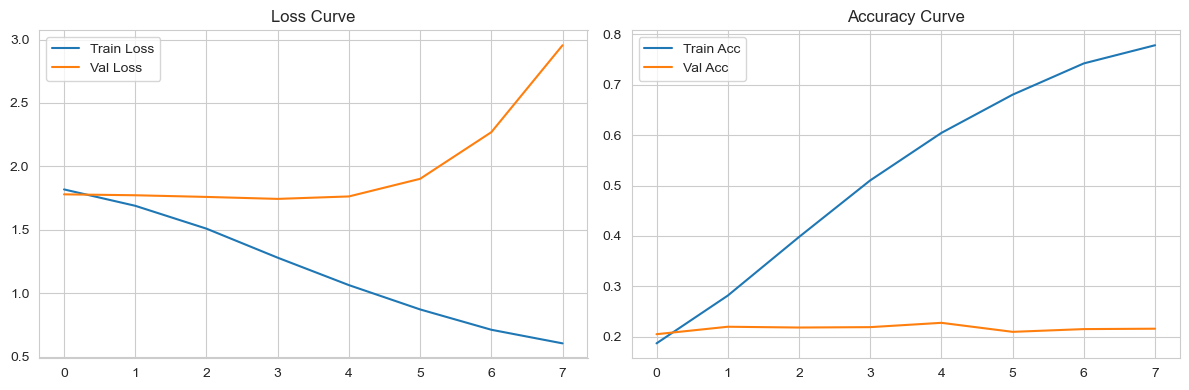

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.14      0.01      0.02        92
           1       0.24      0.41      0.30       249
           2       0.29      0.10      0.15       212
           3       0.23      0.31      0.26       265
           4       0.26      0.24      0.25       241
           5       0.24      0.20      0.22       208

    accuracy                           0.24      1267
   macro avg       0.23      0.21      0.20      1267
weighted avg       0.24      0.24      0.22      1267



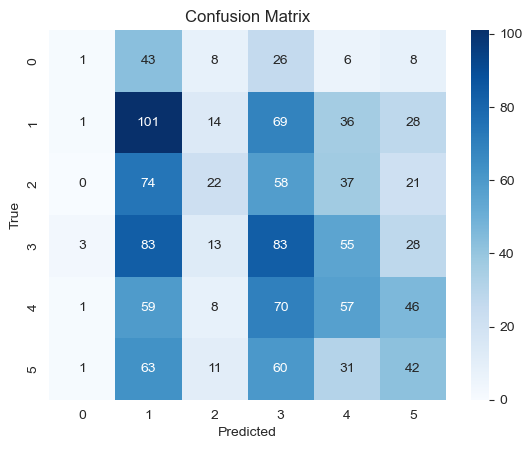

✅ 预测结果已保存至 ./predict_result_lstm.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# =========================
# 1. 数据加载 + 二分类标签映射
# =========================

train_path = "../liar_dataset/processed_dataset/processed_train.csv"
valid_path = "../liar_dataset/processed_dataset/processed_valid.csv"
test_path  = "../liar_dataset/processed_dataset/processed_test.csv"

train_data = pd.read_csv(train_path)
valid_data = pd.read_csv(valid_path)
test_data  = pd.read_csv(test_path)

# 原始可能是 [0,1,2,3,4,5] 或者文本
# 先保证它们都已经是数字(如果是文本可先做 text->num)
def remap_to_binary(label_value):
    """
    这里假设 label_value 取值 0~5，
    其中 [0,1,2] => 0 (fake) ，[3,4,5] => 1 (real)
    """
    return 0 if label_value in [0,1,2] else 1

# 如果当前已经是文本，就要先做 label_mapping
if train_data["label"].dtype == object:
    label_mapping = {
        "pants-fire":   0,
        "false":        1,
        "barely-true":  2,
        "half-true":    3,
        "mostly-true":  4,
        "true":         5
    }
    train_data["label"] = train_data["label"].map(label_mapping)
    valid_data["label"] = valid_data["label"].map(label_mapping)
    test_data["label"]  = test_data["label"].map(label_mapping)

# 再做二分类映射
train_data["label"] = train_data["label"].apply(remap_to_binary)
valid_data["label"] = valid_data["label"].apply(remap_to_binary)
test_data["label"]  = test_data["label"].apply(remap_to_binary)

# =========================
# 2. Tokenizer & Padding
# =========================

max_words = 5000
max_len   = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data["clean_statement"])

train_seq = tokenizer.texts_to_sequences(train_data["clean_statement"])
valid_seq = tokenizer.texts_to_sequences(valid_data["clean_statement"])
test_seq  = tokenizer.texts_to_sequences(test_data["clean_statement"])

train_seq = pad_sequences(train_seq, maxlen=max_len, padding='post', truncating='post')
valid_seq = pad_sequences(valid_seq, maxlen=max_len, padding='post', truncating='post')
test_seq  = pad_sequences(test_seq, maxlen=max_len, padding='post', truncating='post')

train_labels = train_data["label"].values
valid_labels = valid_data["label"].values
test_labels  = test_data["label"].values

# =========================
# 3. 构建 LSTM 模型（二分类）
# =========================

model_2class = models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=128),
    layers.Bidirectional(layers.LSTM(128, return_sequences=False)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # 二分类，单神经元 + sigmoid
])

model_2class.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',  # 二分类
    metrics=['accuracy']
)

# =========================
# 4. 模型训练
# =========================

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

history_2class = model_2class.fit(
    train_seq, train_labels,
    epochs=20,
    batch_size=128,
    validation_data=(valid_seq, valid_labels),
    callbacks=[early_stop],
    verbose=2
)

# =========================
# 5. 可视化训练过程
# =========================

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_2class.history['loss'], label='Train Loss')
plt.plot(history_2class.history['val_loss'], label='Val Loss')
plt.title('2-class LSTM - Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_2class.history['accuracy'], label='Train Acc')
plt.plot(history_2class.history['val_accuracy'], label='Val Acc')
plt.title('2-class LSTM - Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# =========================
# 6. 模型评估与预测
# =========================
y_pred_prob_2class = model_2class.predict(test_seq)
# 概率大于0.5则判定为1，否则0
y_pred_2class = (y_pred_prob_2class > 0.5).astype("int32").reshape(-1)

print("=== 2-Class Classification Report ===\n")
print(classification_report(test_labels, y_pred_2class, target_names=["fake","real"]))

cm_2class = confusion_matrix(test_labels, y_pred_2class)
plt.figure(figsize=(5,4))
sns.heatmap(cm_2class, annot=True, fmt="d", cmap="Blues",
            xticklabels=["fake","real"], yticklabels=["fake","real"])
plt.title("Confusion Matrix - 2 Class")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# =========================
# 7. 导出预测结果
# =========================
result_df_2class = pd.DataFrame({
    "id": test_data["id"],
    "true_label": test_labels,
    "predicted_label": y_pred_2class
})
result_df_2class.to_csv("./predict_result_lstm_2class.csv", index=False)
print("✅ [2分类] 预测结果已保存至: ./predict_result_lstm_2class.csv")
